# (2024) Graded Exam 1: Document Recognition

## Please write your name and student ID here: FIRSTNAME Lastname (Anthony Grégoire Kalaydjian - 370837)

#### For submission, make sure to save your notebook with valid outputs for grading. Do not leave a lot of confusing debug output in your cells. 

In this exam, we are going to tackle a simple computer vision task from start to finish using classical methods. Given a scanned image of an anonymous satisfaction questionnaire filled out via pen, our job is to fully automatically extract the responder's answers. 

Almost all of the task is guided, and graded parts are marked. Here's an overview of the steps we will take, each composed of several subtasks:

1. Implementing a high-performance 2D convolution operation. **(30 points)**
2. Detecting horizontal and vertical edges with Sobel filtering and thresholding. **(10 points)**
3. Improving detected edges via dilation. **(15 points)**
4. Labeling connected components to detect table lines. **(25 points)**
5. Processing the detected lines into boxes and deciding which boxes are filled to extract the final answers. **(20 points)**

**100 points** in total.

**Hint:** All graded parts start with the heading "Subtask". Searching for "Subtask" with Cmd/Ctrl + F can help you check out all the graded parts. All code you need to write is also marked with `[TODO]`. 

**INSURANCE NOTE:** It is possible to move from one step to the next even if your implementation for that step is failing, by using an alternative library function or loading the correct result from disk. Look for notes marked with **INSURANCE NOTE** just like this one!

## About Possible Technical Problems

This lab does not require any different packages than those you have used in the labs: `numpy`, `matplotlib`, `scipy` and `scikit-image`. In case you do get some errors while trying to run the notebook, there are two things you can try:
1. Try to re-install packages with versions that are known to work (running the cell below).
2. Run the notebook on Google Colab, which has all the libraries pre-installed.

**In any case, please feel free to call a TA and ask for help if you are having trouble.**

In [ ]:
# uncomment and run the below code in case you have library issues to try to have working versions installed
# %pip install numpy==1.24.3 matplotlib==3.7.2 scipy==1.11.1 scikit-image==0.20.0 jupyter==1.0.0

## The Questionnaire

Let's start with some imports, and then load up the questionnaire image that we will be processing. While the purpose of the system we're designing could be processing thousands of questionnaires automatically, we're only going to focus on a single, well-aligned instance for the sake of simplicity.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as conv
import skimage.morphology
import skimage.measure
import skimage.draw

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

def show_image(image, title, ticks='off', **kwargs):
    """ helper function to imshow without surrounding ticks """
    if 'dpi' not in kwargs:  # high by default
        kwargs['dpi'] = 300 
    plt.figure(**kwargs)
    plt.imshow(image)
    plt.title(title)
    if ticks == 'off':
        plt.xticks([])
        plt.yticks([])
        
def show_image_pair(img1, title1, img2, title2, ticks='off', **kwargs):
    if 'dpi' not in kwargs:  # high by default
        kwargs['dpi'] = 300 
    plt.subplots(1, 2, **kwargs)
    plt.subplot(121)
    plt.xticks([]); plt.yticks([]); plt.title(title1)
    plt.imshow(img1)
    plt.subplot(122)
    plt.xticks([]); plt.yticks([]); plt.title(title2)
    plt.imshow(img2);

Image shape: (1200, 1700)
Image data type: float32
Image value range: [0.0, 1.0]


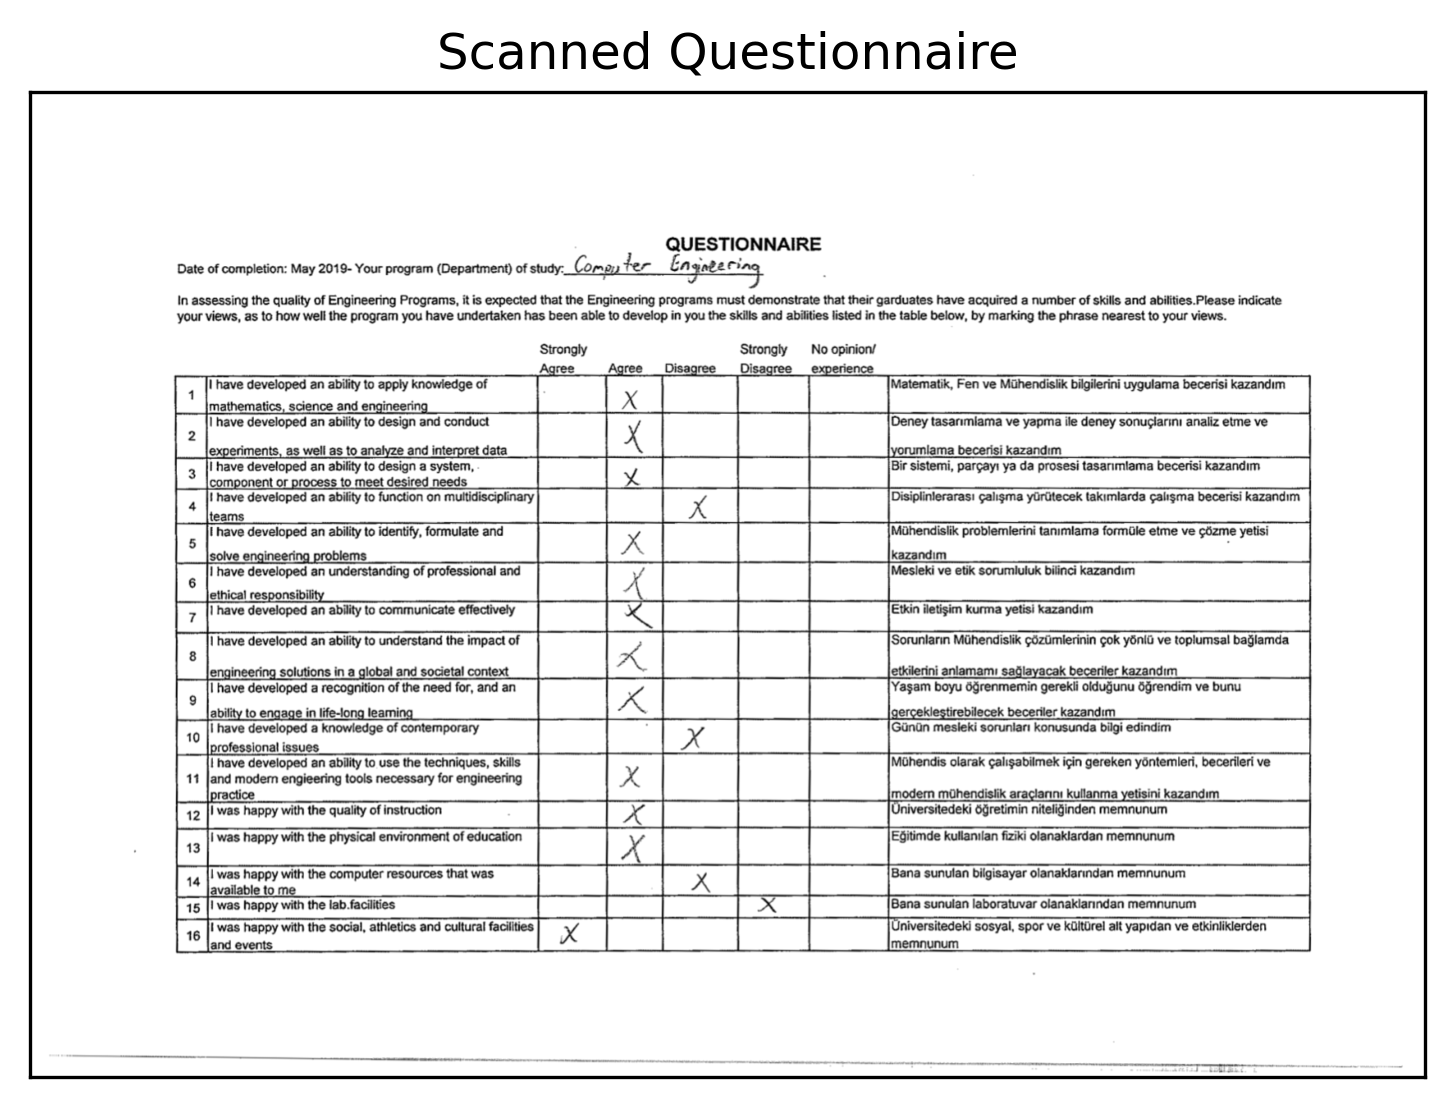

In [2]:
image = plt.imread('resources/questionnaire.png')
print(f'Image shape: {image.shape}')
print(f'Image data type: {image.dtype}')
print(f'Image value range: [{image.min()}, {image.max()}]')
show_image(image, 'Scanned Questionnaire', dpi=300)

Our goal is to find which boxes have been selected automatically. 

## TASK 1: High-Performance 2D Convolution (30 points)

As you might have already seen in class and implemented in the previous lab, convolution operation involves applying a filter to sliding window on an image.

![](resources/image_filter_naive.png)

You have already implemented this using a nested for loop with elementwise multiplication and subsequent summation for each patch. 

Now we are going to use an improved alternative algorithm where we cast the problem as a single matrix multiplication. 

Intuitively, the idea is to transform the patches such that we can apply filter to all patches simultaneously.

The first step is to create a matrix of size `[Kernel_Height * Kernel_Width]x[Num_Patches]` which contains all the patches that will be convolved. This is done by extracting all patches, flattening and stacking them.

This matrix can then be multiplied by a flattened kernel to get the result of the convolution which can then be reshaped back to 2D. The image below where a 3x4 image is convolved with a 2x2 kernel should help understand this process. The final output vector can be reshaped into 2x3 to get the convolved image.

![](resources/patches_to_matrix.png)

Note that the kernel is also 2D at first and also needs to be flattened. Of course, it must first be flipped for the convolution to be correct. For the above example, the original 2x2 filter (or kernel) would be the following:

$$
\text{Kernel} = \begin{bmatrix}
z & y \\
x & w \\
\end{bmatrix}
\xrightarrow[]{\text{flip}}
\begin{bmatrix}
w & x \\
y & z \\
\end{bmatrix}
\xrightarrow[]{\text{flatten}}
\begin{bmatrix}
w & x & y & z \\
\end{bmatrix}
$$

Which corresponds to the above figure after flipping and flattening. Equivalently, the kernel can be flattened first and then flipped, which is easier to implement:

$$
\text{Kernel} = \begin{bmatrix}
z & y \\
x & w \\
\end{bmatrix}
\xrightarrow[]{\text{flatten}}
\begin{bmatrix}
z & y & x & w \\
\end{bmatrix}
\xrightarrow[]{\text{flip}}
\begin{bmatrix}
w & x & y & z \\
\end{bmatrix}
$$

### Subtask 1.1: `patches_to_matrix` (20 points)

In [197]:
# Implement the following fuction to produce the matrix of patch columns as detailed above.
def patches_to_matrix(input_data, kernel_height, kernel_width):
    """
    Converts a grayscale image into its column representation based on the specified filter size.

    Parameters:
        input_data (numpy.ndarray): Input image data of shape (height, width).
        kernel_height (int): Height of the kernel.
        kernel_width (int): Width of the kernel.

    Returns:
        numpy.ndarray: Two-dimensional column matrix representation of the input image.
    """

    h, w = input_data.shape

    # Calculate output dimensions of the convolution. 
    output_height = (h - kernel_height) + 1
    output_width = (w - kernel_width) + 1

    # Initialize the image column matrix. It should have as many rows as the number of
    # pixels in the kernel, and as many columns as the number of pixels in the output image.
    column_matrix = np.zeros((kernel_height * kernel_width, output_height * output_width))

    # Iterate through each position of the sliding window and fill the output columns
    # by putting one patch on each column, going from top-left to bottom-right. 
    k = 0
    for i in range(output_height):
        for j in range(output_width):
            # [TODO] Extract the 2D patch corresponding to the current output pixel.
            patch = input_data[i:i+kernel_height, j:j+kernel_width]

            # [TODO] Flatten the patch and put it into a column in the matrix.
            #  Hint: np.ravel flattens a given array.
            column_matrix[:, k] = np.ravel(patch)
            k += 1

    return column_matrix

### Subtask 1.2: `conv2d` (10 points)

In [198]:
# Now, implement the convolution function based on the description above. 
def conv2d(img, kernel):
    """
    Apply discrete 2D convolution between img and kernel. Always uses "same" padding for simplicity.

    Parameters:
        img (numpy.ndarray): Input image data of shape (height, width).
        kernel (numpy.ndarray): Kernel of shape (kernel_height, kernel_width).

    Returns:
        numpy.ndarray: Convolution result, having the same shape as the input image.
    """
    
    h, w = img.shape
    kh, kw = kernel.shape
    assert kh % 2 == 1 and kw % 2 == 1, 'Kernel size should be odd!'

    # Apply "same" padding, to keep the output size the same as the input size.
    ph = (kh - 1) // 2
    pw = (kw - 1) // 2
    img = np.pad(img, ((ph, ph), (pw, pw)), mode='constant')
    
    # Get the column matrix representation of the padded image. 
    cols = patches_to_matrix(img, kh, kw)

    # [TODO] Convolve the column matrix representation with the kernel using matrix multiplication.
    #  Hint: Remember that the kernel should be flipped to match the definition of convolution. 
    #        For simplicity, you can flatten the kernel first and then reverse it with np.flip. 
    conv_vector = np.flip(kernel.flatten())@cols

    # Reshape the result vector to the correct original output shape. 
    conv = conv_vector.reshape(h, w)

    return conv

#### Testing the convolution

In [199]:
# Define filter size, stride and padding
filter_height = 3
filter_width = 5

# Seed for repeatability
np.random.seed(442)

# Define a random filter
filter_ = np.random.rand(filter_height, filter_width)

# Create random input image
input_image = np.random.rand(64, 64)  # (height, width)

# Our implementation
our_result = conv2d(input_image, filter_)

# Scipy implementation
scipy_result = conv.convolve2d(input_image, filter_, mode='same')

# Check if both implementations produce the same output
assert np.allclose(our_result, scipy_result), 'conv2d output does not match scipy!'
print("Error in results:", np.sum(np.abs(our_result - scipy_result)))

Error in results: 1.6635581800983346e-12


## TASK 2: Simplified Edge Detection (10 points)

**There is no coding for this part, only written questions at the end!**

In this part, we will use the `conv2d()` function that we just implemented, to extract the horizontal and vertical edges using the Sobel filter. After filtering, we threshold the image to convert it to binary before further processing.

**INSURANCE NOTE:** If your `conv2d(...)` function does not work correctly, you can replace it with `conv.convolve2d(..., mode='same')` instead below. 

In [200]:
# Uncomment and run below line if your conv2d does not work, to replace it with scipy's:
# def conv2d(*args): return conv.convolve2d(*args, mode='same')

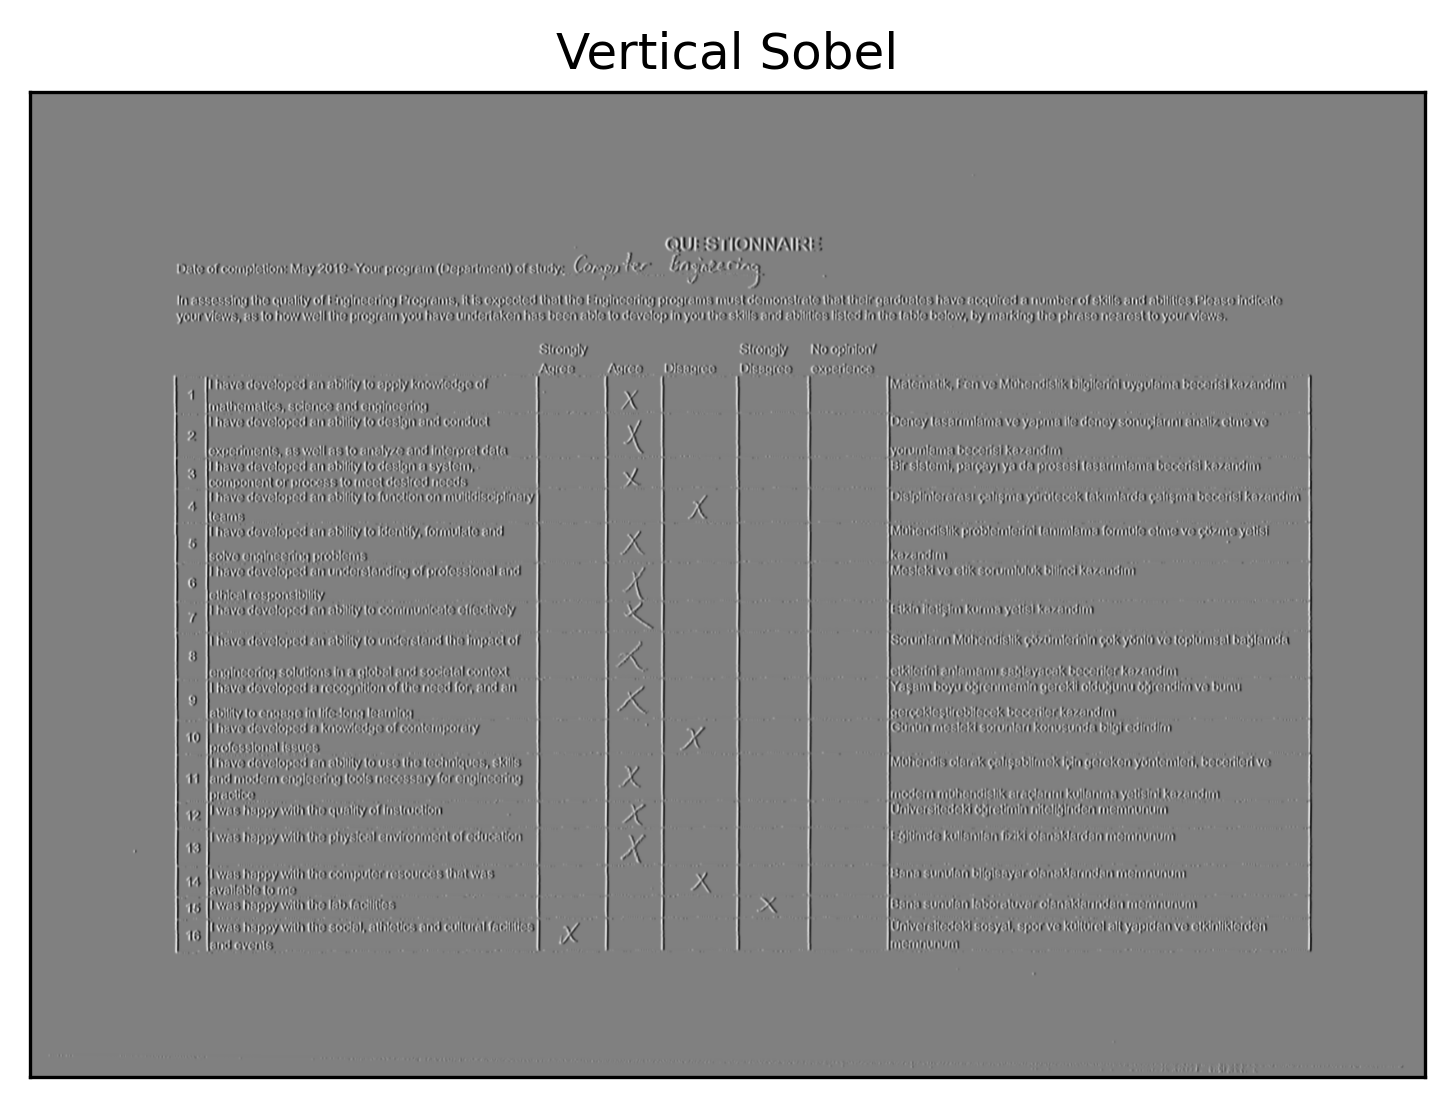

In [201]:
# Let's first start with the vertical edges!
# # Define Sobel filter and apply with conv2d. 

sobel = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]], dtype=image.dtype) 

sobel_vertical = conv2d(image, sobel)
show_image(sobel_vertical, 'Vertical Sobel', dpi=300)

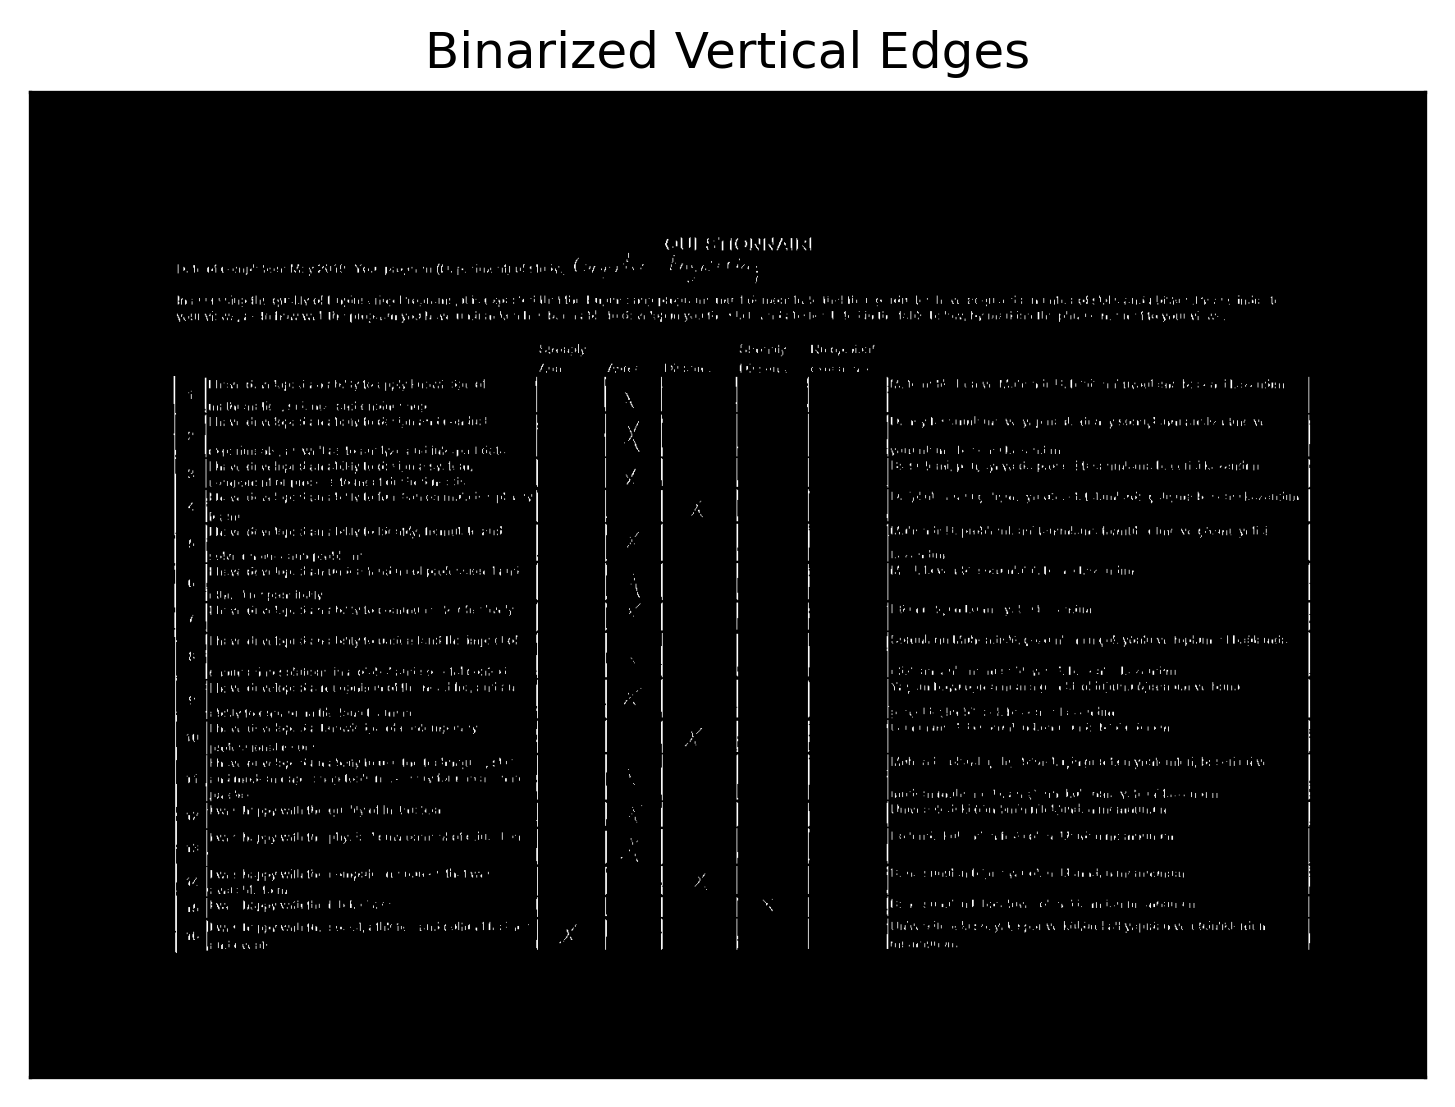

In [205]:
# Then, we apply thresholding to convert it to a binary image.

def threshold(img, t1, t2):
    """ 1 for pixels in [t1, t2], 0 otherwise. """
    return np.where((t1 <= img) & (img <= t2), 1.0, 0.0)

edges_vertical = threshold(sobel_vertical, 2.0, 4.0)
show_image(edges_vertical, "Binarized Vertical Edges", dpi=300)

### Subtask 2.1: Written Question (5 points)

We chose the range [2.0, 4.0] for binarizing the edges detected by the Sobel filter. Why did we choose these two values specifically? Why did we ignore negative values including the range [-4.0, -2.0]? 

**Hint:** You can play with the threshold above to help you answer this question, but remember to set it back to the original before continuing!

**ANSWER HERE:** We want to determine high gradient values, as it seems by plotting the results for different thresholds that vertical lines have especially high gradient componenets in them. Therefore, we ignore negative values. If we had kept negative values, we would have also extracted low gradient values.

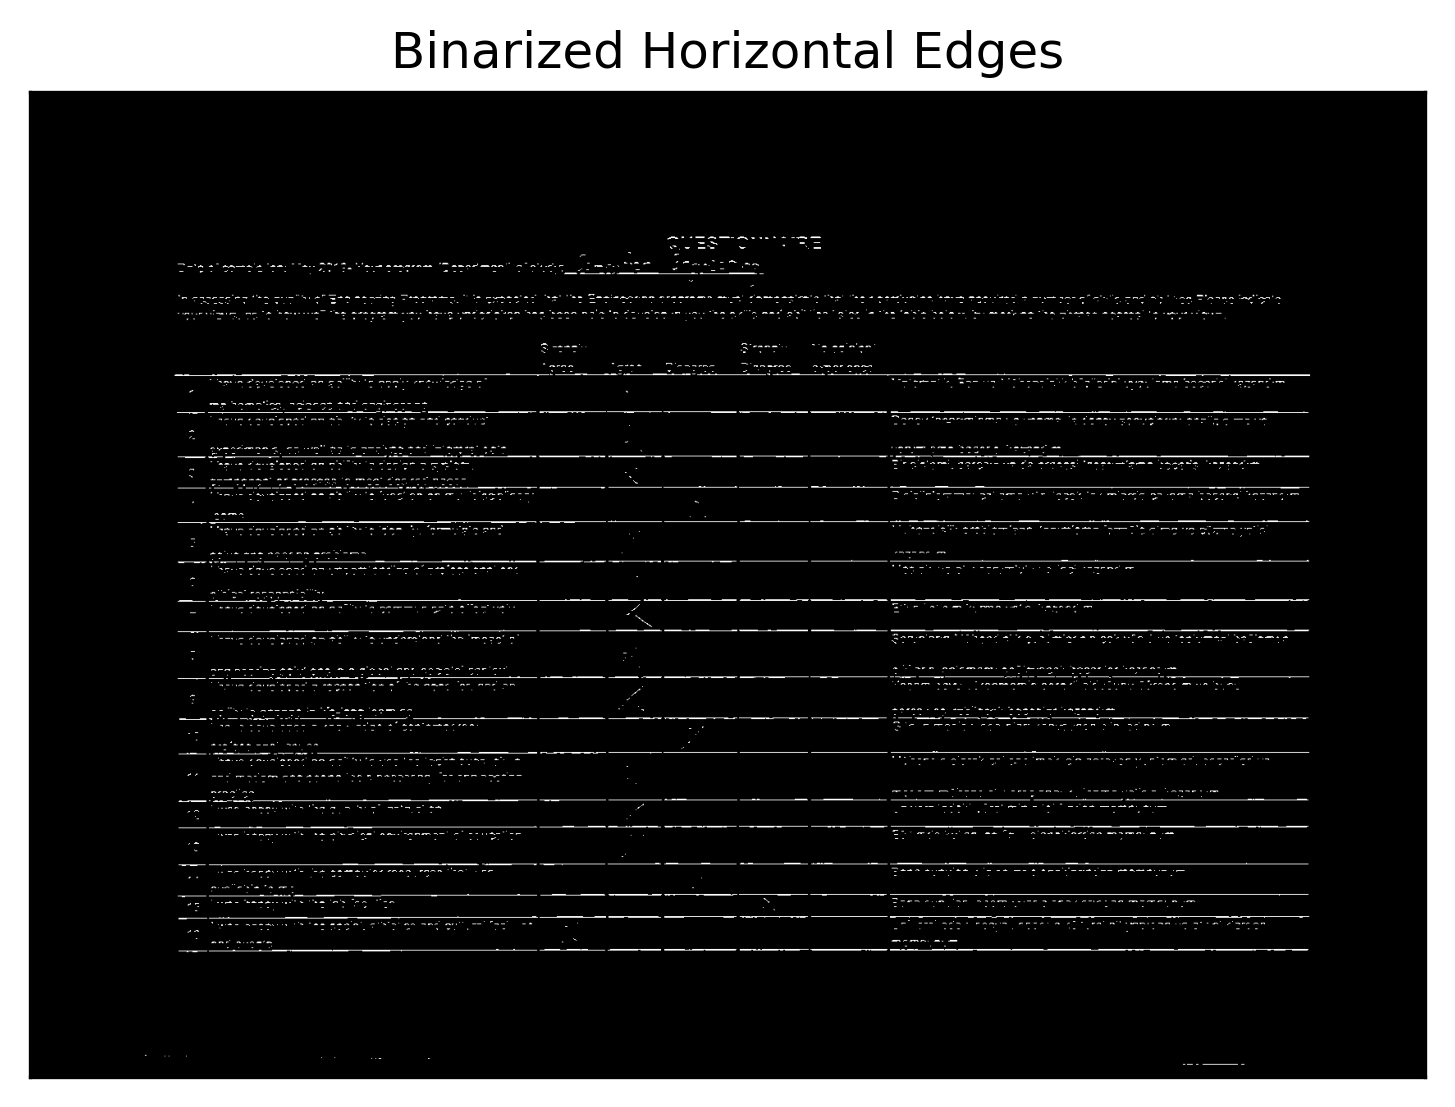

In [207]:
# Repeat the same process for horizontal edges.
sobel_horizontal = conv2d(image, sobel.T)
edges_horizontal = threshold(sobel_horizontal, 2.0, 4.0)
show_image(edges_horizontal, 'Binarized Horizontal Edges', dpi=300)

### Subtask 2.2: Written Question (5 points)

If you zoom in onto the horizontal edge image (or the vertical one), you will notice that the table lines are not continuous. In fact, there are quite a few holes in every line! Why do we see these holes, rather than having nice, continuous lines? 

**Hint:** You can run the below cell to see a zoomed-in version of the edges if the question is not clear from the previous figure.

**ANSWER HERE:** This happens at the crossing with vertical lines. At these exact points, the Sobel filter becomes zero.

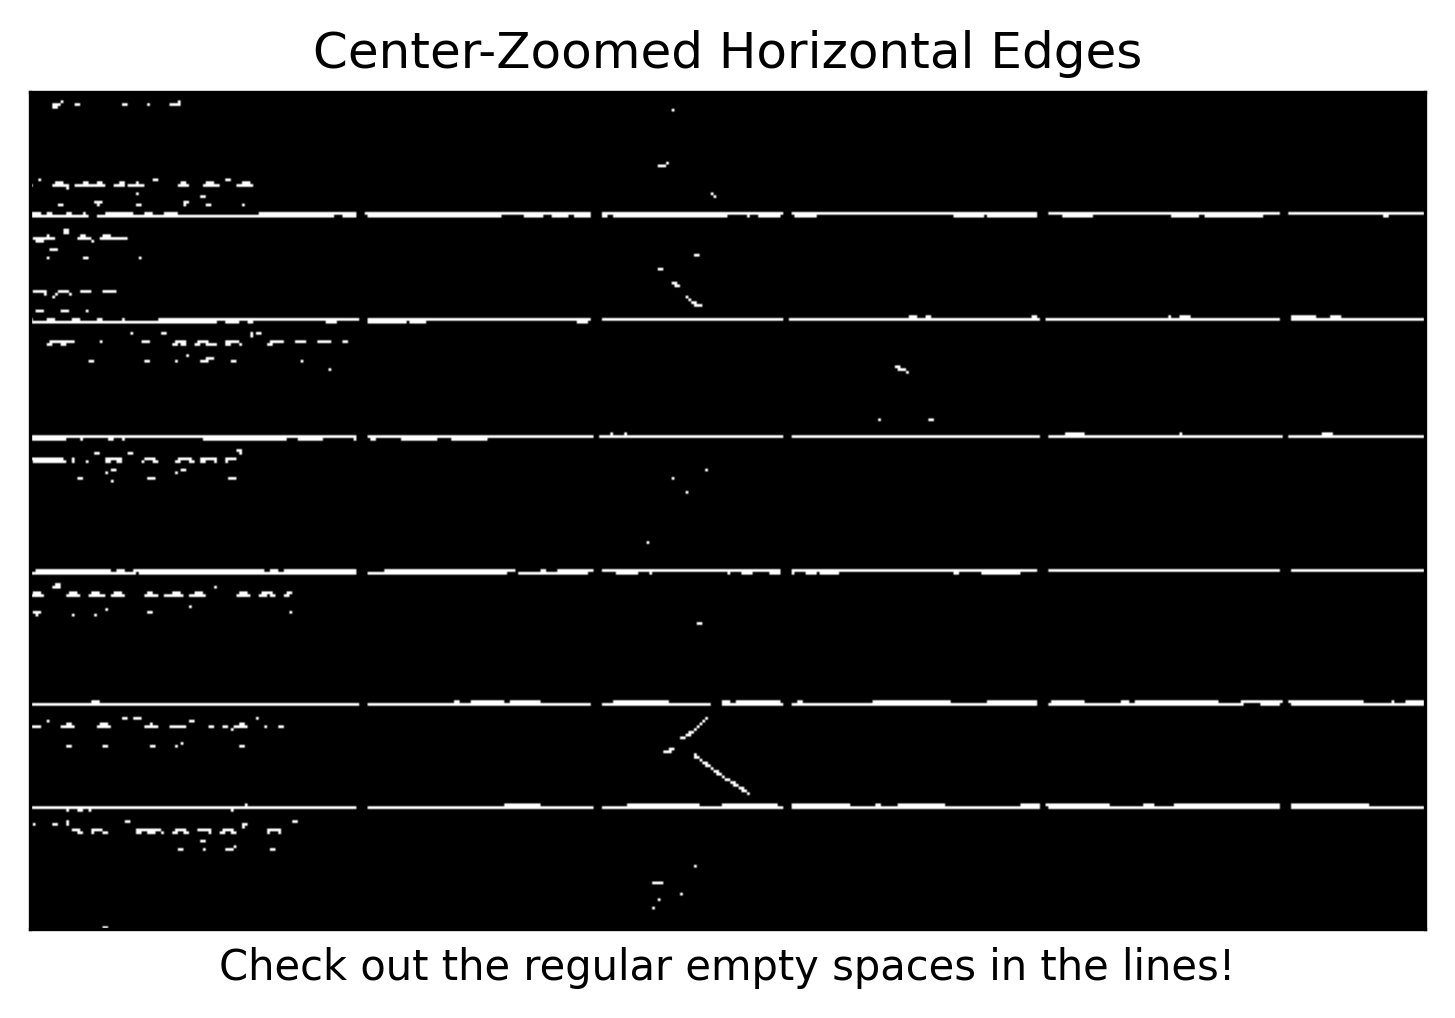

In [208]:
edges_cut = edges_horizontal[400:700, 500:1000]
show_image(edges_cut, 'Center-Zoomed Horizontal Edges', dpi=300)
plt.xlabel('Check out the regular empty spaces in the lines!');

## TASK 3: Convolution Based Dilation (15 points)

Now that we have the binary images containing vertical and horizontal lines, we want to use connected component labeling to group and extract the lines. However, there are holes in the lines preventing us from applying connected component labeling. In this step, we will implement 'dilation' to process the image in order to dilate white regions, connecting the separated line segments and eliminating the holes.

The process of dilation can be easily implemented using convolutions. For example, assume we have a convolutional kernel of all ones:

$$
K = \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

Then the dilation operation will set one pixel to white if there is **at least** one white pixel in the neighborhood defined by the kernel:

![Dilation GIF](resources/dilation_gif.gif)

Here is what we will implement:

1. By applying convolution with a binary kernel $K$ to binary image $I$, compute how many white pixels are in one pixel's neighborhood as defined by $K$. Denote the response as $R$;
2. Transform $R$ to (binary) dilated image output $D$ by setting non-zero entries to $1$ and zero entries to $0$.

For our own dilation we will define two kernels (different to the kernel in the example) to check each pixel's vertical **or** horizontal neighborhood only (the neighborhoods are three pixels including the pixel itself).

**To summarize what to do: Implement the dilation function, define the kernels required in the instructions and apply dilation to the two binary images from previous task, and visualize the dilation results.**

### Subtask 3.1: Dilate (10 points)

Note that this function is defined here but invoked in subtask 3.2, please take a look at subtask 3.2 for context.

In [209]:
def dilate(img, kernel, iters=1):
    """
    Dilate img based on the neighborhood defined by kernel. Repeat this process iters times. 
    
    Parameters:
        img (numpy.ndarray): Binary input image data of shape (height, width).
        kernel (numpy.ndarray): Binary kernel of shape (kernel_height, kernel_width).
        iters (int): Number of times to repeat the dilation.

    Returns:
        numpy.ndarray: Dilated result, having the same shape as the input image.
    """
    assert np.unique(img).size == 2, 'img is not binary!'
    assert np.unique(kernel).size in (1, 2), 'kernel is not binary!'
    
    # [TODO] Apply dilation `iters` times to img. Each dilation is the steps 1. and 2. explained above. 
    output = img
    for _ in range(iters):
        # compute convolution with kernel
        R = conv2d(output, kernel)
        mask = R>0
        output[mask] = 1
        output[~mask]  = 0

    return output

### Subtask 3.2: Kernel Definition (5 points)

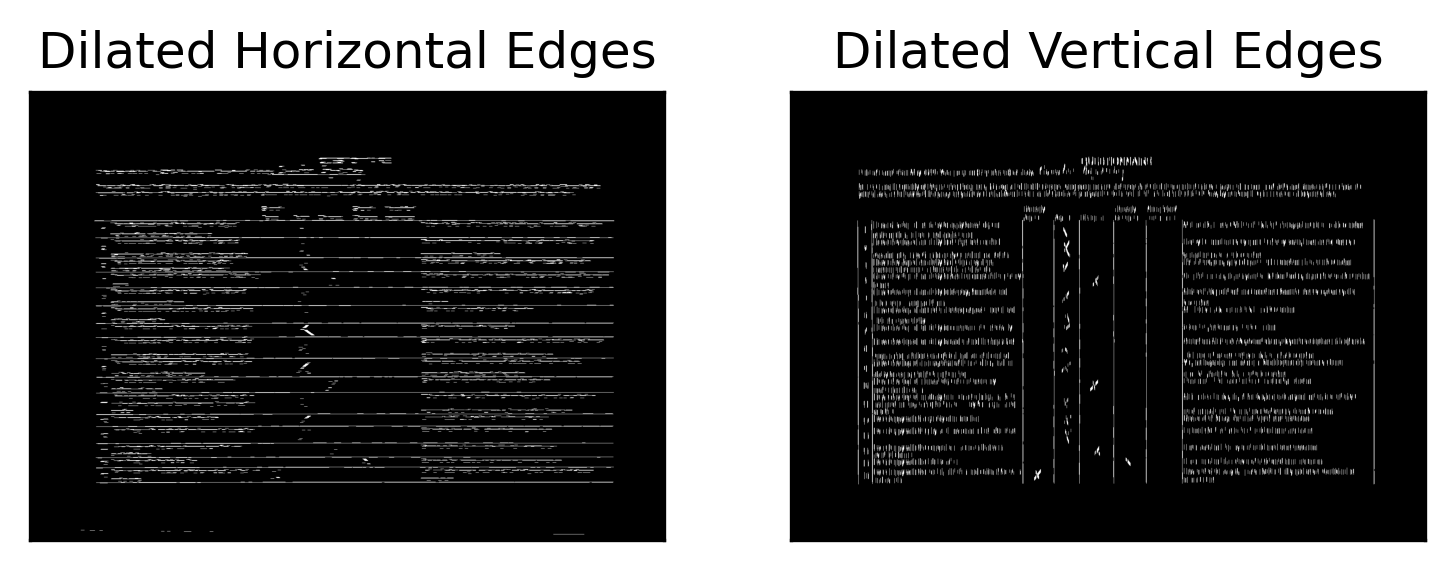

In [210]:

# [TODO] Define the kernel to dilate horizontal edges (left-right neighborhood, three pixels should be 1). 
horiz_kernel = np.array([[1, 1, 1]])

# [TODO] Define the kernel to dilate vertical edges (up-down neighborhood, three pixels should be 1). 
vert_kernel = np.array([[1, 1, 1]]).T

# Dilate the the vertical and horizontal image several times. Can take around 10 seconds.
dilated_vertical_binary_image = dilate(edges_vertical, vert_kernel, 4)
dilated_horizontal_binary_image = dilate(edges_horizontal, horiz_kernel, 4)

# Clean up image borders just in case
def zero_border(img, t=5):
    img[:t, :] = 0
    img[-t:, :] = 0
    img[:, :t] = 0
    img[:, -t:] = 0
zero_border(dilated_vertical_binary_image)
zero_border(dilated_horizontal_binary_image)

# Let's visualize the dilated edges. The lines should be touching at this point. 
show_image_pair(dilated_horizontal_binary_image, 'Dilated Horizontal Edges',
                dilated_vertical_binary_image, 'Dilated Vertical Edges')

## TASK 4: Connected Component Labeling (25 points)

As we've already seen in the apple segmentation task of the first exercise session, connected components labeling scans an image and groups its pixels into components based on pixel connectivity and pixel intensity values, such that all pixels within the same component share similar pixel values and communicate with each other while pixels in different groups do not. Then, the set of connected components partition the image into segments that can be utilized for downstream computer vision tasks.

<center><img src="./resources/Connected_Component_Example.png" width="300"/></center>

> Two pixels p1 and p2 are said to "communicate" if there is at least one path within the component connecting p1 and p2.

In this graded lab, we will use connected component labeling to label vertical and horizontal lines. Segmenting these lines will allow us to locate the position of the answers.

**INSURANCE NOTE:** If your `dilate(...)` function does not work correctly, you can use the below code to load
the provided correct results from disk. 

In [211]:
# dilated_vertical_binary_image = plt.imread('resources/insurance/dil_vert.png')
# dilated_horizontal_binary_image = plt.imread('resources/insurance/dil_horiz.png')

### Subtask 4.1: Region-Growing (15 points)

We use the 4-point neighbors (up, down, left, right) to define pixel connectivity:

<center><img src="./resources/four-points-neighbor.png" width="120"/></center>

However, for boundary points, they have less neighbors. To avoid index out-of-range error, we have to test if a given neigbor pixel is in the image too:

In [212]:
NEIGHBOR_OFFSETS = [(-1, 0), (1, 0), (0, 1), (0, -1)]

def is_in_image(image, i, j):
    return 0 <= i < image.shape[0] and 0 <= j < image.shape[1]

As a simple, albeit not very high-performance implementation, we will use the region-growing algorithm for labeling connected components:
1. Define the input image $I$, connection map $C$, stack $S=[\ ]$, component ID $n=1$<br><br>
2. Take one unassigned non-zero pixel from the image, and push it to the stack.<br>
   i.e. $p \in I$, $p \rightarrow S$<br><br>
3. Conduct region growing with the stack $S$:<br>
    3.1 While $S$ is not empty, pop 1 pixel out;<br>
    &emsp;&ensp;$S \rightarrow p_s$<br>
    3.2 Assign component ID $n$ to the pixel<br>
    3.3 Find the 4-point neighbors $p_n$ of $p_s$<br>
    3.4 Push the neighbor $p_n$ to $S$ if its pixel value is 1 and it hasn't been assigned a component ID:<br>
    &emsp;&ensp;If $I(p_n) = 1$ and $C(p_n) = 0$ then $p \rightarrow S$<br>
    3.5 Back to step 3.1<br><br>
5. One component has been fully labeled. Update component ID: $n = n+1$<br><br>
6. Back to step 2 until all pixels have been processed.

In [214]:
def grow_region(image, component_map, pixel_stack, cid):
    """
    Grow a region from the given pixel in the pixel_stack.

    Parameters:
        image (numpy.ndarray): Binary input image data of shape (height, width).

        component_map (numpy.ndarray): Integer array with the same shape as the
                                       image, storing the component ID of each pixel.

        pixel_stack (list): A list of seed pixels from which the region grows.

        cid (int): the component ID to be assigned to the pixels of the grown region.

    Returns:
        None.
        (The grown region is saved in the updated component_map.)

    """
    
    # While the pixel stack is not empty, we assign the pixels within the stack to the given 
    # component ID and add their valid neighbors to this pixel stack. In this way, when the
    # loop ends, the region will cover all reachable pixels, which is recognized as a component. 
    while pixel_stack:
        # [TODO] Get and remove one element (pixel) from the pixel_stack.
        # Hint: use the pop() method of python list
        row, col = pixel_stack.pop()

        # Assign the component ID to the pixel
        component_map[row, col] = cid

        # Get the 4-point neighbors given the offset
        for row_off, col_off in NEIGHBOR_OFFSETS:
            # [TODO] Determine neighbor coordinates. 
            neighbor_row = row + row_off
            neighbor_col = col + col_off

            # [TODO] If the neighbor is inside the image, its pixel value is not zero and it 
            # has not been assigned a component ID, add the pixel to the pixel_stack.
            # Hint: use the function is_in_image(); 
            #       check the value of the pixel in the image and component_map
            if (is_in_image(image, neighbor_row, neighbor_col) and (image[neighbor_row, neighbor_col] != 0) and component_map[neighbor_row, neighbor_col]==0):
                pixel_stack.append((neighbor_row, neighbor_col))

        # Hint: monitor the length of pixel_stack to avoid infinite loops. The length should
        #       increase from 1 and decrease back to 0
        # print(len(pixel_stack))


def find_connected_components(image):    
    """
    Label connected components in a given binary image. 
    
    Parameters:
        image (numpy.ndarray): Binary input image data of shape (height, width).

    Returns:
        numpy.ndarray: Integer image, with a unique ID set for each connected component, 0 for background.
        int: The number of connected components in the image. 
    """
    assert np.unique(image).size == 2, 'the input image is not binary'

    # Prepare component ID and component map
    cid = 1
    component_map = np.zeros(image.shape, dtype=np.int32)

    # For each pixel in the image, if its value is non-zero and it has not been assigned a 
    # component ID, add it to the stack and invoke the grow_region from it. 
    # grow_region will assign all its connected pixels to the current component ID.
    num_row, num_col = image.shape
    for row in range(num_row):
        for col in range(num_col):
            
            # [TODO] Check the condition to start growing, explained in the comment right above. 
            if ((image[row, col] != 0) and component_map[row, col]==0):

                # Define the stack with the starting pixel and grow it. 
                pixel_stack = [(row, col)]
                grow_region(image, component_map, pixel_stack, cid)

                # Labeling complete for one component, increment ID.
                cid += 1

    return component_map, cid - 1

#### Testing Labeling

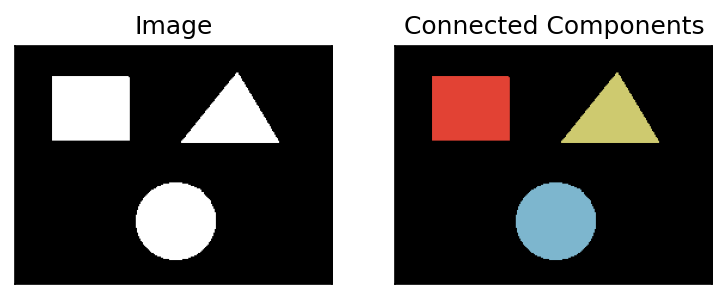

In [215]:
# Let's see if it works on a simple image by visualizing our results with a random color for each CC. 

def color_cc(labels, n, seed=442):
    np.random.seed(seed)
    c = np.zeros((*labels.shape, 3), dtype=np.float32)
    colors = np.random.rand(n + 1, 3)
    colors[0, :] = 0.0  # black for 0 comp.
    return colors[labels]

simple = plt.imread('resources/simple.png')
simple = threshold(simple, 0.75, 1.0)

labels, n = find_connected_components(simple)

show_image_pair(simple, 'Image', color_cc(labels, n), 'Connected Components', dpi=150)

In [216]:
# Compare our result with skimage.measure.label. Can take around 10 seconds or more. 
our_labels, our_n = find_connected_components(dilated_horizontal_binary_image)
sk_labels, sk_n = skimage.measure.label(dilated_horizontal_binary_image, connectivity=1, return_num=True)

arr_eq = np.array_equal(our_labels, sk_labels)
assert our_n == sk_n and arr_eq, 'results does not match skimage.measure.label!'
print('OK!')

OK!


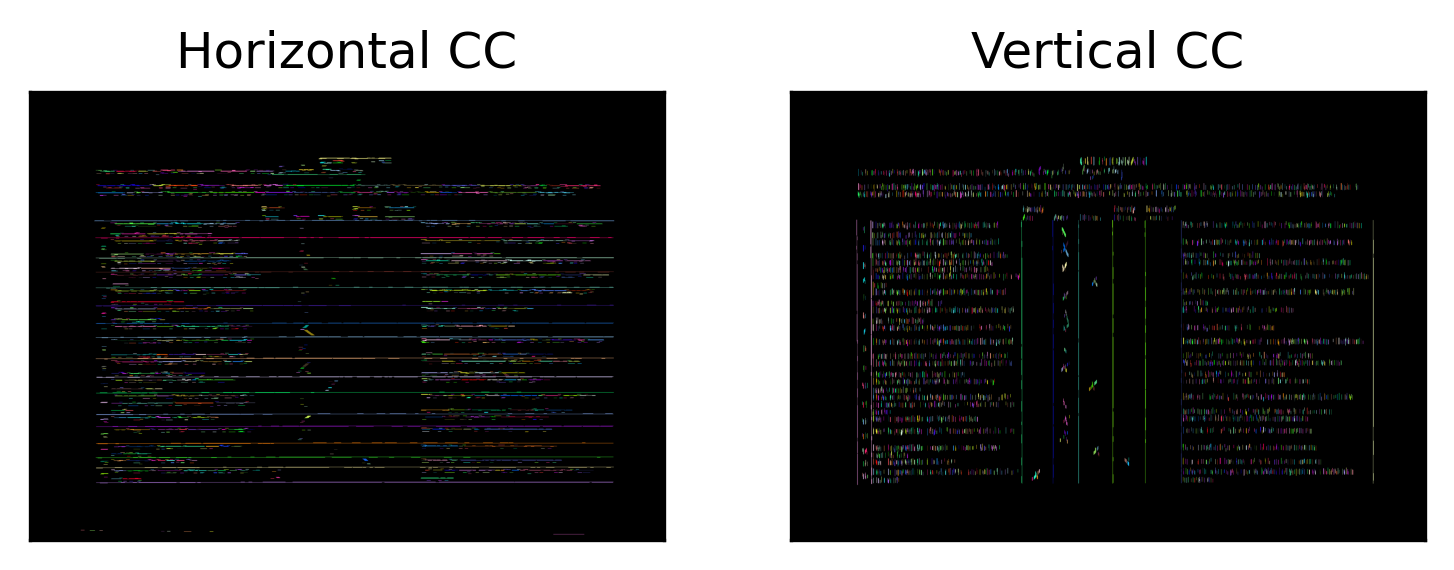

In [217]:
# Now, let's calculate and visualize the horizontal and vertical components. 
horiz_labels, horiz_n = our_labels, our_n
vert_labels, vert_n = find_connected_components(dilated_vertical_binary_image)

show_image_pair(color_cc(horiz_labels, horiz_n), 'Horizontal CC', color_cc(vert_labels, vert_n), 'Vertical CC')

### Subtask 4.2: Finding vertical and horizontal lines (10 points)

After getting the connected components, you should be able to see above that each line is its own component with some extra noise, but there's also a lot of other small ones. Knowing that we would like to detect only the lines, we can filter components by their length.

The easiest way is to get the leftmost, rightmost, topmost, and bottommost pixel coordinates of each component, and then calculate the vertical and horizontal span to only keep very long or tall connected components.

**INSURANCE NOTE:** If your `find_connected_components(...)` function does not work correctly, you can use `skimage.measure.label(..., return_num=True)` instead as an alternative. Uncomment and run the below code in that case. 

In [ ]:
# horiz_labels, horiz_n = skimage.measure.label(dilated_horizontal_binary_image, return_num=True)
# vert_labels, vert_n = skimage.measure.label(dilated_vertical_binary_image, return_num=True)

In [218]:
# Given the connection map and number of connected components, find the vertical and horizontal lines.
def find_lines(labels, ncc):
    height, width = labels.shape
    
    # We're going to store the coordinates of each pixel in every component
    cc_pixels = [[] for _ in range(ncc + 1)]
    
    # Make a pass over every non-zero pixel, and add it to the components list
    rows, cols = np.nonzero(labels != 0)  # Coordinates of each pixel that are not background
    for i, j in zip(rows, cols):
        cc_pixels[labels[i, j]].append(np.array([i, j], dtype=np.int32))
        
    # Convert the lists to (N, 2) arrays for convenience, 
    # where N is the number of pixels in the component
    for i, pixel_list in enumerate(cc_pixels):
        if pixel_list:
            cc_pixels[i] = np.stack(pixel_list, axis=0)
            
    # Now, cc_pixels[cid] is an (N, 2) array containing i, j coords of all pixels
    # belonging to component with id #cid. 
    # It is equivalent to np.nonzero(labels == cid). 

    # Loop over each component
    lines = []
    for cid in range(1, ncc + 1):
        pixels = cc_pixels[cid]  # (N, 2) shape, i and j coordinate of each pixel in the CC
        rows = pixels[:, 0]      # i coordinate of each pixel
        cols = pixels[:, 1]      # j coordinate of each pixel
        
        # [TODO] Find the coordinates of the leftmost and rightmost pixel in the CC.
        #        You can break ties any way you want to; it does not matter for the result. 
        left = np.minimum(pixels, axis=0)  # the coordinate should have shape (2,), for i and j
        right = np.maximum(pixels, axis=0)
        
        # [TODO] Find the coordinates of the top and bottom pixel in the CC.
        top = np.minimum(pixels, axis=1)
        bot = np.maximum(pixels, axis=1)

        # [TODO] Only keep the components with enough span: 
        #        More than half the image height for vertical lines 
        #        OR more than half the image width for horizontal lines. 
        if ...:
            lines.append((top, bot, left, right))
            
    # Will have shape (num_lines, 4, 2), having 4 (i, j) points for each line. 
    return np.array(lines)

vert_lines = find_lines(vert_labels, vert_n)
horiz_lines = find_lines(horiz_labels, horiz_n)

print('Vertical lines (should be 9):', vert_lines.shape[0])
print('Horizontal lines (should be 17):', horiz_lines.shape[0])

Vertical lines (should be 9): 3548
Horizontal lines (should be 17): 1672


In [ ]:
# Let's draw the lines on the image to see if they are correct!
def draw_lines(image, vert_lines, horiz_lines, color, overlay=False):
    visual = np.zeros((*image.shape, 3), dtype=np.float32)
    
    if overlay:
        visual[...] = image[..., np.newaxis]

    for t, b, l, r in vert_lines:
        rr, cc, value = skimage.draw.line_aa(*t, *b)
        visual[rr, cc] = value[:, np.newaxis] * color
        
    for t, b, l, r in horiz_lines:
        rr, cc, value = skimage.draw.line_aa(*l, *r)
        visual[rr, cc] = value[:, np.newaxis] * color
        
    return visual

white = np.ones(3)
lines_drawn_black = draw_lines(image, vert_lines, horiz_lines, white)

red = np.array([1.0, 0.0, 0.0])
lines_drawn_overlay = draw_lines(image, vert_lines, horiz_lines, red, overlay=True)
show_image_pair(lines_drawn_black, "Detected Lines", lines_drawn_overlay, "Overlaid on Image", dpi=200)

The detected lines should be overlaid perfectly on top of the lines in the original image!

## TASK 5: Detecting the Marked Boxes (20 points)

And we're finally at the final step... We're going to cross the detected lines to determine the coordinates of each box, and then find out which box is marked in each row. 

**INSURANCE NOTE:** If the lines you detected are incorrect, you can load correct lines directly from the disk by uncommenting and running the below cell.

In [130]:
vert_lines = np.load('resources/insurance/vert.npy')
horiz_lines = np.load('resources/insurance/horiz.npy')

### Subtask 5.0: Finding box corner coordinates (given)

The first part is determining the box coordinates, which is pretty boring, so we've already implemented it. We determine the box corners, and then slightly shrink them so that they do not contain the table lines but only the content. We end with a visualization. Run the cell below and move on!

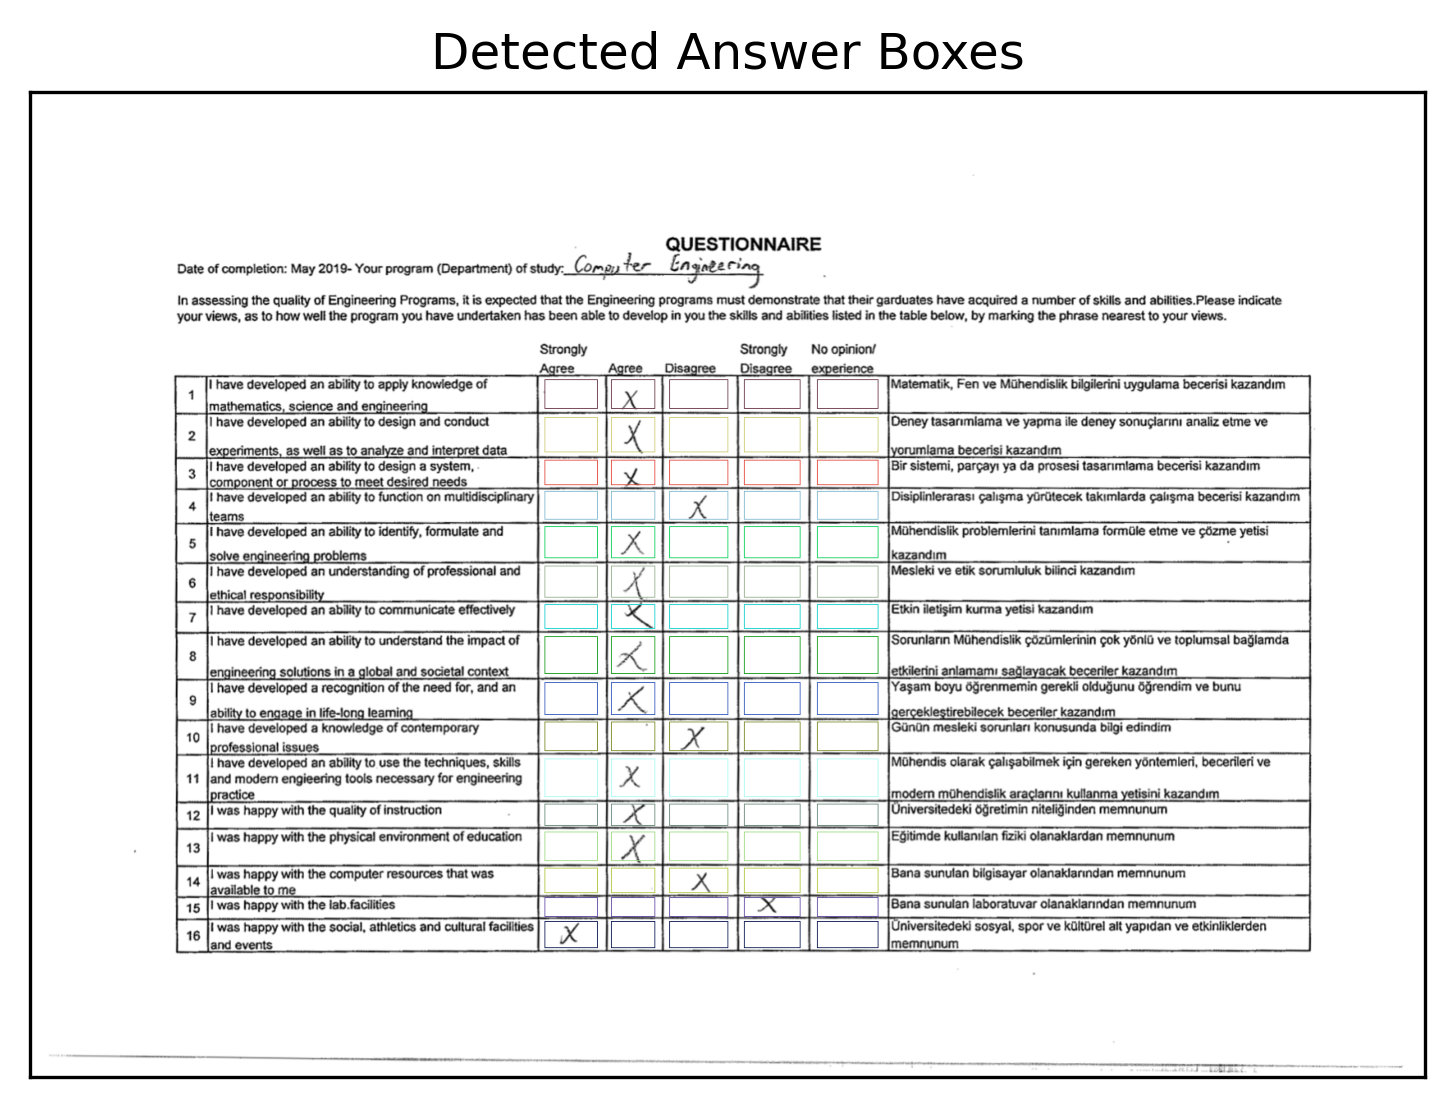

In [131]:
# You **DO NOT** need to read this code. Feel free to skip this cell after running it.  

def determine_boxes(h_lines, v_lines):
    # Sort lines left-to-right, top-to-bottom first.
    h_lines = h_lines[np.argsort(h_lines[:, 0, 0]), ...]
    v_lines = v_lines[np.argsort(v_lines[:, 0, 1]), ...]
    
    # Reminder: lines are [t, b, l, r]
    boxes = []
    for top_line, bot_line in zip(h_lines, h_lines[1:]):
        row = []
        i0 = np.mean(top_line[2:3, 0])
        i1 = np.mean(bot_line[2:3, 0])
        for left_line, right_line in zip(v_lines, v_lines[1:]):
            j0 = np.mean(left_line[0:2, 1])
            j1 = np.mean(right_line[0:2, 1])
            row.append([[i0, j0], [i1, j1]]) # each box is (2, 2): top-left and bot-right corner.
        boxes.append(row)
    return np.array(boxes) # (Nrows, Nboxes_per_row, 2, 2) shaped

def shrink_boxes(boxes, factor=0.9):
    half = 0.5 * (1.0 - factor)
    p0 = (1.0 - half) * boxes[..., 0, :] + half * boxes[..., 1, :]
    p1 = half * boxes[..., 0, :] + (1.0 - half) * boxes[..., 1, :]
    return np.stack((p0, p1), axis=2)

def draw_box(image, box, color):
    ii, jj = skimage.draw.rectangle_perimeter(start=box[0], end=box[1])
    image[ii, jj] = color

def draw_boxes(boxes):
    np.random.seed(442)
    flat_boxes = [b for r in boxes for b in r]
    visual = np.zeros((*image.shape, 3), image.dtype)
    visual[:, :, :] = image[:, :, np.newaxis]
    for row in boxes:
        color = np.random.rand(3)
        for box in row:
            draw_box(visual, box, color)
    return visual
    
boxes = determine_boxes(horiz_lines, vert_lines)
boxes = boxes[:, 2:7, :, :]  # keep only the answer boxes
boxes = shrink_boxes(boxes, factor=0.75)
visual = draw_boxes(boxes)
show_image(visual, "Detected Answer Boxes")

### Subtask 5.1: Finding box pixel coordinates (10 points)

At this point, we have `boxes`, a `(16, 5, 2, 2)` shaped array, containing 16 rows, 5 columns of boxes. For a box indexed as `i, j`, its top-left corner is in `boxes[i, j, 0, :]`, and its bottom-right corner in `boxes[i, j, 1, :]`. 

Since we're interested in examining the pixels inside each box, we should find the pixel coordinates contained inside each box for indexing the contents.

In [151]:
def pixel_coordinates(box):
    """
    Determine pixel coordinates inside a given box. 
    
    Parameters:
        box (numpy.ndarray): Array of shape (2, 2) containing the top-left and bottom-right corner of the box. 

    Returns:
        ii (numpy.ndarray): i (row) coordinate of each pixel in the box
        jj (numpy.ndarray): j (column) coordinate of each pixel in the box
    """
    
    # [TODO] Find the row and column indices spanned by the box. 
    #  Hint: np.arange goes a long way. Make sure the coordinates are integers.

    top_left = box[0,:]
    bottom_right = box[1,:]

    i_span = np.arange(top_left[0], bottom_right[0], dtype=np.int64)
    j_span = np.arange(top_left[1], bottom_right[1], dtype=np.int64)
    
    # [TODO] Generate all coordinates by taking the cartesian product of the spans.
    #        np.meshgrid is great for this. 
    ii, jj = np.meshgrid(i_span, j_span, indexing='ij')
    
    # [TODO] Again, make sure you wrote your code so that ii and jj are integers, not floats!
    
    return ii, jj

Now, let's visualize the box patches extracted by our code. They should clearly correspond to box contents, with only one marked box in each row of the figure. 

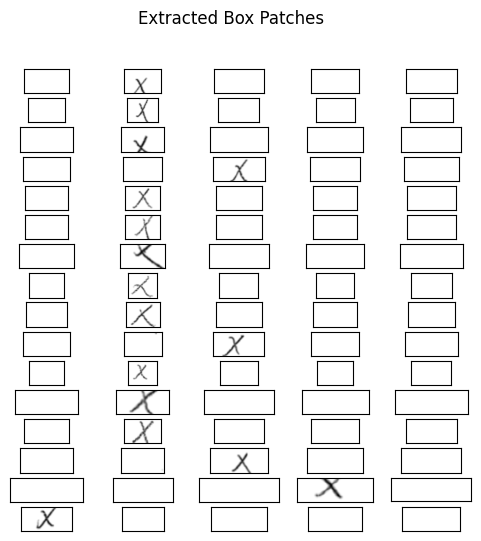

In [152]:
plt.subplots(16, 5, dpi=100)
plt.suptitle('Extracted Box Patches')
k = 1
for i, row in enumerate(boxes):
    for j, box in enumerate(row):
        ii, jj = pixel_coordinates(box)
        plt.subplot(16, 5, 5 * i + j + 1)
        plt.imshow(image[ii, jj], vmin=0, vmax=1)
        plt.xticks([]); plt.yticks([])
        k += 1

### Subtask 5.2: Determining the marked box (10 points)

Here we are. Now that we have the patches for each row, we have to decide which box is marked. How you do it is entirely up to you this time! Make sure to explain your approach with a short comment.

In [ ]:
def determine_marked_box(row_box_patches):
    """
    Determine which box is marked, given the box patches for a single row. 
    
    Parameters:
        row_box_patches (list): A list of 5 patches of shape (H, W), the pixel contents of each box in
                                the row. Each patch may have a different shape. 

    Returns:
        int: The index of the marked box. Either 0, 1, 2, 3 or 4. 
    """
    
    # [TODO] Explain your approach in 1-2 sentences. 
    
    # [TODO] Find the marked box and return it! Somehow...
    i = ...
    
    return i

In [ ]:
# Now, let's see what happens with your code! 

# Aggregate the answers
answers = []
for row in boxes:
    patches = []
    for box in row:
        ii, jj = pixel_coordinates(box)
        patches.append(image[ii, jj])
    answer = determine_marked_box(patches)
    answers.append(answer)
    
# Print out the answers we've determined
answer_text = [
    'Strongly Agree',
    'Agree',
    'Disagree',
    'Strongly Disagree',
    'No opinion/experience'
]
for i, answer in enumerate(answers, 1):
    print(f'Question {i}:\t{answer_text[answer]}')
    
# Show the original questionnaire for comparison
show_image(image, 'Questionnaire')

# Check correctness
correct = answers == [1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 0]
assert correct, "Answers are not correct!"
if correct:
    print('You were able to detect the answers correctly...')
    print('***** CONGRATULATIONS *****')

Hopefully everything is correct and you're left with satisfaction! Otherwise, please feel free to go back and fix missing parts.